# Training Model Prediksi Pengeluaran (Time Series) - Final

Notebook ini berisi alur kerja lengkap untuk membangun model prediksi pengeluaran menggunakan **TensorFlow**. Proses ini mencakup semua perbaikan dan logika yang benar, mulai dari pemrosesan data mentah hingga penyimpanan model yang siap digunakan.

**Alur Kerja:**
1.  **Muat & Proses Data**: Memuat data transaksi dan mengubahnya menjadi data deret waktu (total pengeluaran per hari).
2.  **Scaling Data**: Menyamakan skala seluruh data pengeluaran menggunakan `MinMaxScaler`.
3.  **Windowing**: Mengubah data deret waktu menjadi format *supervised learning* (`X` dan `y`).
4.  **Membangun Model TensorFlow**: Merancang arsitektur *Dense Neural Network* (DNN) untuk regresi.
5.  **Training & Evaluasi**: Melatih dan mengevaluasi performa model dalam skala Rupiah.
6.  **Menyimpan Artifak**: Menyimpan model (`.h5`) dan *scaler* (`.pkl`).

## Import Library

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

print("TensorFlow Version:", tf.__version__)
print("Semua library berhasil di-import.")

TensorFlow Version: 2.6.0
Semua library berhasil di-import.


## 1. Muat dan Agregasi Data Transaksi

Kita akan memuat `Personal Budget Transactions Dataset.csv`. Langkah pertama dan paling krusial adalah mengubah data transaksi individual ini menjadi data deret waktu yang memiliki satu nilai agregat per hari. Kita akan memfilter hanya transaksi pengeluaran (di mana kategori bukan 'Income') lalu menjumlahkannya per hari.

Data Pengeluaran Harian (Time Series) Siap Olah:


,date,amount
0,2022-07-06 00:00:00+00:00,129.38
1,2022-07-07 00:00:00+00:00,20.73
2,2022-07-08 00:00:00+00:00,21.02
3,2022-07-09 00:00:00+00:00,58.70
4,2022-07-10 00:00:00+00:00,51.00


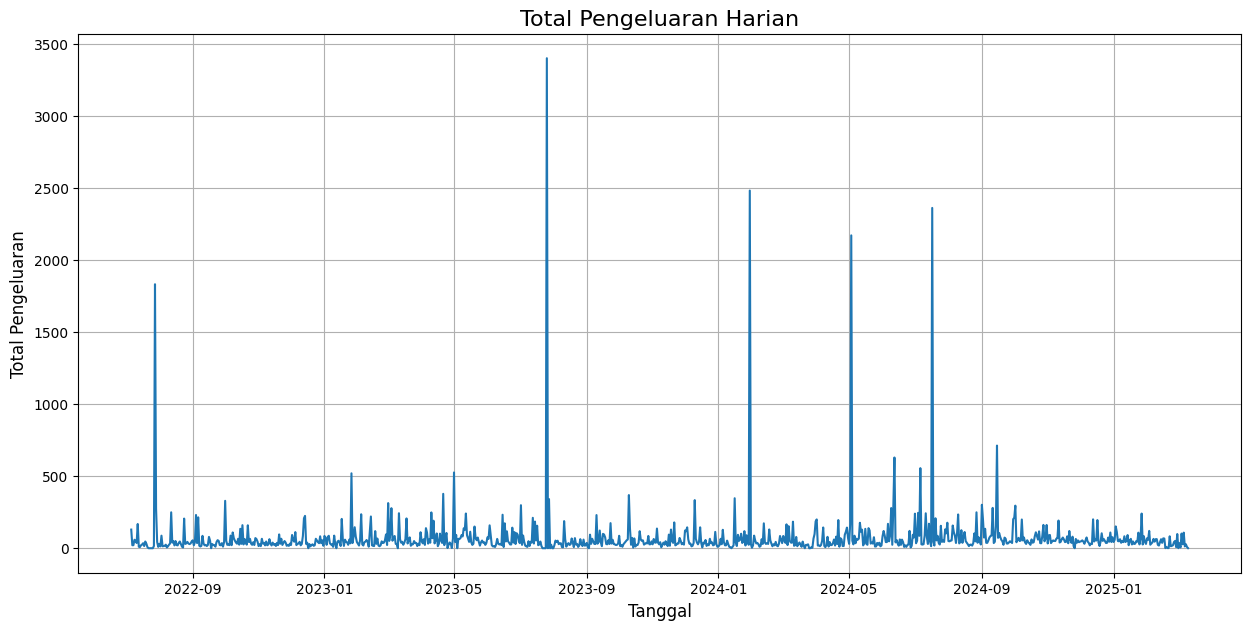

In [12]:
# Muat dataset dan langsung parse kolom 'Date' sebagai datetime
df = pd.read_csv('Personal Budget Transactions Dataset.csv', parse_dates=['date'])

# Filter hanya transaksi pengeluaran (kategori BUKAN 'Income')
df_expense = df[df['category'] != 'income'].copy()

# Agregasi data pengeluaran per hari.
# resample('D') memastikan semua hari dalam rentang waktu ada.
# .fillna(0) mengisi hari tanpa transaksi dengan nilai 0.
daily_spending = df_expense.set_index('date').resample('D')['amount'].sum().fillna(0).reset_index()

print("Data Pengeluaran Harian (Time Series) Siap Olah:")
display(daily_spending.head())

# Visualisasi data harian untuk melihat polanya
plt.figure(figsize=(15, 7))
plt.plot(daily_spending['date'], daily_spending['amount'])
plt.title('Total Pengeluaran Harian', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pengeluaran', fontsize=12)
plt.grid(True)
plt.show()

## 2. Scaling Data

Jaringan saraf tiruan bekerja optimal dengan data berskala kecil (biasanya antara 0 dan 1). Kita akan men-scale **seluruh data pengeluaran harian** *sebelum* membaginya menjadi data latih. Scaler ini kemudian kita simpan karena akan sangat penting untuk digunakan kembali saat inferensi.

In [14]:
# Inisialisasi Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ambil nilai pengeluaran harian dan reshape
spending_values = daily_spending['amount'].values.reshape(-1, 1)

# Latih scaler dan transformasikan seluruh data
scaled_spending = scaler.fit_transform(spending_values)

# Simpan scaler ini ke dalam file .pkl. Ini adalah artifak penting.
with open('scaler_prediksi.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler berhasil dibuat dan disimpan sebagai 'scaler_prediksi.pkl'")

Scaler berhasil dibuat dan disimpan sebagai 'scaler_prediksi.pkl'


## 3. Membuat Dataset "Windowing"

Sekarang kita ubah data deret waktu yang sudah di-scale menjadi format *supervised learning*. Logikanya: **Gunakan data 7 hari terakhir (`X`) untuk menebak hari ke-8 (`y`)**.

In [15]:
def create_windowed_dataset(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:(i + window_size)])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 7
# Buat dataset dari data 'scaled_spending'
X, y = create_windowed_dataset(scaled_spending, window_size=WINDOW_SIZE)

# Reshape X agar sesuai dengan input Dense layer (jumlah_sampel, jumlah_fitur)
X = X.reshape(X.shape[0], X.shape[1])

print(f"Bentuk X (data latih): {X.shape}")
print(f"Bentuk y (data target): {y.shape}")

Bentuk X (data latih): (973, 7)
Bentuk y (data target): (973, 1)


## 4. Pembagian Data Latih dan Uji

Data yang sudah dalam format windowing kini siap dibagi menjadi 80% untuk data latih dan 20% untuk data uji. Untuk data deret waktu, penting untuk tidak mengacaknya (`shuffle=False`).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print("Jumlah Data Latih:", X_train.shape[0])
print("Jumlah Data Uji:", X_test.shape[0])

Jumlah Data Latih: 778
Jumlah Data Uji: 195


## 5. Membangun Model Regresi TensorFlow

Kita bangun arsitektur Dense Neural Network (DNN) sederhana untuk tugas regresi ini. Lapisan output hanya memiliki 1 neuron tanpa fungsi aktivasi (`linear`) untuk memprediksi nilai numerik.

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Output layer untuk regresi
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


## 6. Melatih Model

Kita latih model dengan data yang sudah di-scaling. Kita gunakan 100 *epoch* dan data validasi untuk memantau performa.

In [18]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=2,
    batch_size=16
)

Epoch 1/100
49/49 - 3s - loss: 0.0039 - mean_absolute_error: 0.0207 - val_loss: 4.2806e-04 - val_mean_absolute_error: 0.0117
Epoch 2/100
49/49 - 1s - loss: 0.0038 - mean_absolute_error: 0.0207 - val_loss: 4.3848e-04 - val_mean_absolute_error: 0.0111
Epoch 3/100
49/49 - 0s - loss: 0.0038 - mean_absolute_error: 0.0196 - val_loss: 4.6564e-04 - val_mean_absolute_error: 0.0146
Epoch 4/100
49/49 - 0s - loss: 0.0037 - mean_absolute_error: 0.0203 - val_loss: 4.3361e-04 - val_mean_absolute_error: 0.0112
Epoch 5/100
49/49 - 0s - loss: 0.0038 - mean_absolute_error: 0.0196 - val_loss: 4.3024e-04 - val_mean_absolute_error: 0.0109
Epoch 6/100
49/49 - 0s - loss: 0.0038 - mean_absolute_error: 0.0200 - val_loss: 4.3503e-04 - val_mean_absolute_error: 0.0137
Epoch 7/100
49/49 - 0s - loss: 0.0037 - mean_absolute_error: 0.0207 - val_loss: 5.6440e-04 - val_mean_absolute_error: 0.0184
Epoch 8/100
49/49 - 0s - loss: 0.0037 - mean_absolute_error: 0.0207 - val_loss: 4.2141e-04 - val_mean_absolute_error: 0.0112


## 7. Evaluasi Model dan Visualisasi

Kita evaluasi performa model pada data uji. Sangat penting untuk mengembalikan hasil prediksi dan data uji ke **skala Rupiah asli** menggunakan `scaler.inverse_transform()` agar kita bisa menginterpretasikan hasilnya dengan benar.


Mean Absolute Error (MAE) pada Data Uji: Rp 42.14
Artinya, rata-rata kesalahan prediksi model adalah sekitar Rp 42 dari nilai sebenarnya.


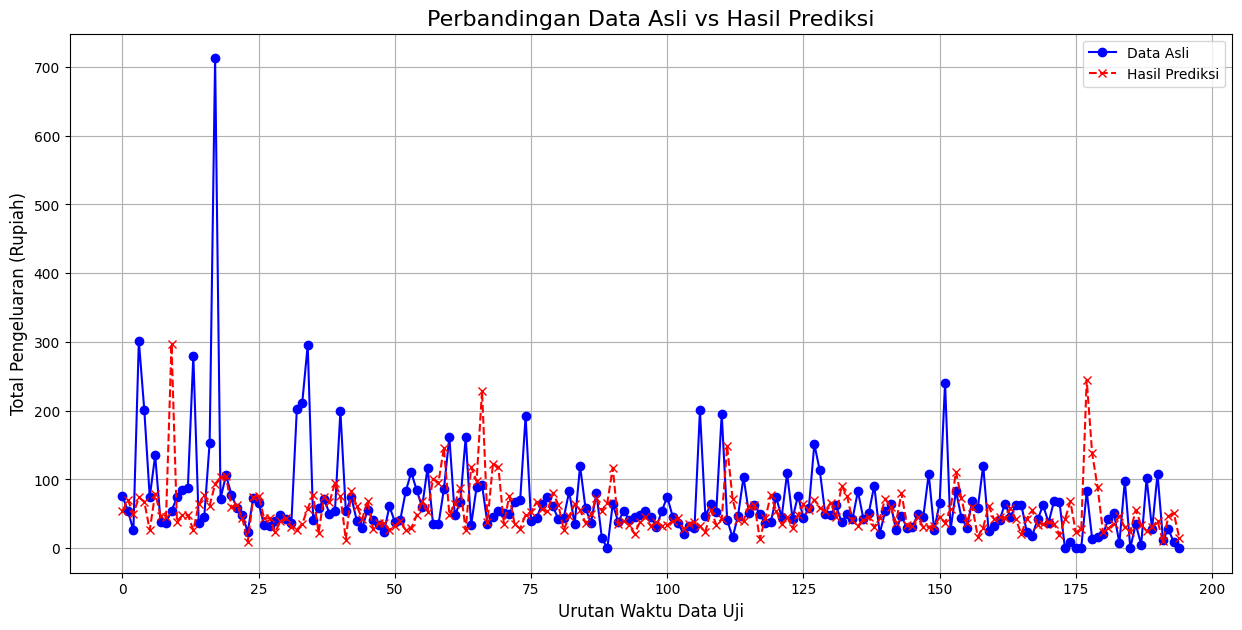

In [19]:
# Lakukan prediksi pada data uji (hasilnya masih dalam skala 0-1)
predictions_scaled = model.predict(X_test)

# Kembalikan prediksi ke skala Rupiah asli
predictions = scaler.inverse_transform(predictions_scaled)

# Kembalikan data uji y ke skala Rupiah asli untuk perbandingan
y_test_real = scaler.inverse_transform(y_test)

# Hitung MAE (Mean Absolute Error) dalam skala Rupiah
mae = tf.keras.losses.mean_absolute_error(y_test_real.flatten(), predictions.flatten()).numpy()

print(f"\nMean Absolute Error (MAE) pada Data Uji: Rp {mae:,.2f}")
print(f"Artinya, rata-rata kesalahan prediksi model adalah sekitar Rp {mae:,.0f} dari nilai sebenarnya.")

# Visualisasi Hasil
plt.figure(figsize=(15, 7))
plt.plot(y_test_real, label='Data Asli', color='blue', marker='o')
plt.plot(predictions, label='Hasil Prediksi', color='red', linestyle='--', marker='x')
plt.title('Perbandingan Data Asli vs Hasil Prediksi', fontsize=16)
plt.xlabel('Urutan Waktu Data Uji', fontsize=12)
plt.ylabel('Total Pengeluaran (Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 8. Menyimpan Model Final

Langkah terakhir adalah menyimpan model yang sudah dilatih ke dalam format `.h5` yang andal.

In [20]:
model.save('model_prediksi.h5')
print("\nModel berhasil disimpan sebagai 'model_prediksi.h5'")


Model berhasil disimpan sebagai 'model_prediksi.h5'


## Kesimpulan

Proses training telah selesai. Kita berhasil membangun sebuah model prediksi pengeluaran harian dari data transaksi mentah. Dua artifak penting telah dihasilkan dan siap digunakan untuk inferensi:
1.  **`model_prediksi.h5`** (Model TensorFlow yang sudah dilatih)
2.  **`scaler_prediksi.pkl`** (Scaler untuk memproses data baru)